# CSC-180 Mini-Project 3: Computer Vision Using GPU and Transfer Learning
In this project, our team examined the outcome of training two different computer vision image classification models in order to read and predict images from the CIFAR-10 dataset, which is included with TensorFlow. We provide solutions for two different approaches: a standard convolutional neural network directly using the CIFAR-10 dataset, and a transfer learning model based on the pre-trained VGG16. 

In [70]:
# Noah Venethongkham, 219660117
# Ashley Thor, 219334909
# Lucas Saechao, 218794239
# CSC 180 - Intelligent Systems
# Mini-Project 3
# April 2, 2021

# TensorFlow Helper Functions
The following functions assist with data preprocessing: specifically, they are used to build our feature vector.

##Predictors and Input
* **missing_median(df, name)**
 * If an input is missing, this function will replace it with the median value from that column.
* **encode_text_dummy(df, name)**
 * This function is used to encode textual or categorical values.
* **encode_numeric_zscore(df, name, mean, sd)**
 * This function is used to encode numeric values.
 
## Output
* **encode_text_index(df, name)**
 * This function is used to encode textual or categorical output values.
* **to_xy(df, target)**
 * This function is used to produce a final feature vector along with an expected output. 

In [71]:
# matplotlib
%matplotlib inline
from matplotlib.pyplot import figure, show
import matplotlib.pyplot as plt

# numpy and pandas
import numpy as np
import pandas as pd

# scikit learn
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, log_loss
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import column_or_1d
import sklearn.feature_extraction.text as sk_text
import skimage.transform


# tensorflow and keras
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, Conv2D, MaxPooling2D
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.optimizers import Adam

# python libraries
import requests
import shutil
import json
import time
import csv
import io
import os

# if OS is windows, import chime
if os.name == 'nt':
    import winsound

In [72]:
# Useful functions
import tensorflow as tf
from collections.abc import Sequence
from sklearn import preprocessing
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os

# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low


In [73]:
# Plots a confusion matrix for the model
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Plot an ROC curve
def plot_roc(pred, y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_area_under_curve = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = $0.2f)' % roc_area_under_curve)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show
    
# Encodes text values into numerical variables
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for i in dummies.columns:
        dummy_name = "{}-{}".format(name, i)
        df[dummy_name] = dummies[i]
    df.drop(name, axis=1, inplace=True)
    
# Normalizes numerical values into a z-score
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()
    if sd is None:
        sd = df[name].std()
    df[name] = (df[name] - mean) / sd
    
# For formatting time
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)
    
# Beep if on a windows machine
if os.name == 'nt':
    def ding():
        winsound.Beep(2000, 300)
        winsound.Beep(2000, 300)
        winsound.Beep(2000, 300)


## Switch and Verify GPU
To enable GPU backend for your notebook. Runtime->Change runtime type->Hardware Accelerator->GPU.

In [74]:
tf.test.gpu_device_name()

'/device:GPU:0'

The above cell should output '/device:GPU:0' in order to verify that this notebook is using the GPU backend.

## Part I:   Image classification without transfer learning

https://www.cs.toronto.edu/~kriz/cifar.html

In [75]:
#  Load cifar-10 data and split it to training and test
from tensorflow.keras.datasets import cifar10

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

num_classes = 10

# The data split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [76]:
# print out data shape

print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)

print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)


print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)
50000 train samples
10000 test samples


array([[[100 168 231]
  [100 168 229]
  [101 167 230]
  ...
  [ 95 165 231]
  [ 94 165 228]
  [ 95 167 229]]

 [[103 170 230]
  [103 168 228]
  [104 168 226]
  ...
  [ 97 167 229]
  [ 97 166 227]
  [ 97 168 229]]

 [[107 174 233]
  [106 172 230]
  [106 173 229]
  ...
  [100 170 230]
  [100 170 230]
  [101 172 232]]

 ...

 [[165 178 177]
  [159 170 167]
  [167 177 170]
  ...
  [ 75 117 154]
  [ 75 120 157]
  [ 72 120 158]]

 [[158 174 172]
  [173 186 182]
  [182 193 188]
  ...
  [ 76 119 154]
  [ 75 119 153]
  [ 77 121 154]]

 [[161 176 174]
  [162 176 172]
  [160 171 169]
  ...
  [ 98 137 167]
  [129 160 183]
  [162 185 202]]])


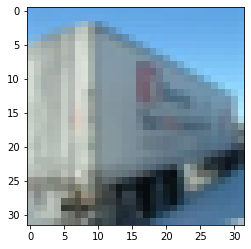

In [77]:
import matplotlib.pyplot as plt

# print image as numpy array
print("array({})".format(x_train[15]))

# print image
plt.imshow(x_train[15])

In [78]:
# Convert y_train and y_test from 2D to 1D 
y_train = y_train.reshape(50000)
y_test = y_test.reshape(10000)

In [79]:
# print y_train/y_test shape
# expected: (50000,)
# expected: (10000,)
print(y_train.shape)
print(y_test.shape)

(50000,)
(10000,)


In [80]:
# Convert class vectors to one hot format
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [81]:
# Convert data from int to float and normalize it
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /= 255

## Finding the best model
The following code algorithmically attempts to determine which combination of activations, optimizers, and neuron counts will produce the best performing model, in terms of F1 Score.

The information about this model is saved to the tuple `best_model`, which contains:
* F1 Score
* Model
* Neuron Count
* (Activation, Optimizer)

This will take a few minutes.

In [82]:
checkpointer = ModelCheckpoint(filepath="cnn/best_weights.hdf5", verbose=0, save_best_only=True) 

activations = ['relu', 'sigmoid', 'tanh']
optimizers = ['adam', 'sgd']
layer_one = [32, 64 ,128, 256]
layer_two = [16, 32, 64, 128]
batch_size = 128

# score, model, neuron count, (activation, optimizer)
best_model = (0, None, None, None)

# loop through configurations
for activation in activations:
    for optimizer in optimizers:
        for neuron_i in layer_one:
            for neuron_j in layer_two:
                #define model
                model = Sequential()

                model.add(
                    Conv2D(
                        32,                             # from input shape
                        kernel_size=(3,3),              
                        strides=(2,2),                  # 2x2 stride
                        padding='same',                 # pad with zeros if it goes over
                        activation=activation,          # for the loop
                        input_shape=x_train.shape[1:]
                    )
                )

                # variable neuron count
                model.add(Conv2D(neuron_i, (3, 3), padding='same'))
                model.add(MaxPooling2D(pool_size=(2, 2)))

                model.add(
                    Conv2D(
                        neuron_j,
                        kernel_size=(3,3),
                        strides=(1,1),
                        padding='same',
                        activation=activation
                    )
                )
                model.add(MaxPooling2D(pool_size=(2, 2)))
                model.add(Flatten())

                model.add(Dense(512))
                model.add(Activation(activation))
                model.add(Dropout(0.5))

                # there should be 10 possible outputs
                model.add(Dense(num_classes, activation='softmax'))

                # compile model
                model.compile(
                    loss='categorical_crossentropy', 
                    optimizer = optimizer
                )

                # early stoppping
                monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')

                start = time.time()

                # fit the model
                model.fit(x_train, y_train, batch_size=batch_size, callbacks=[monitor, checkpointer], epochs=15, verbose=0, validation_data=(x_test, y_test))

                elapsed = time.time() - start
                print ("Elapsed time: {}".format(hms_string(elapsed)))

                pred = model.predict(x_test)
                pred = np.argmax(pred,axis=1)
                y_true = np.argmax(y_test, axis=1)

                score = metrics.accuracy_score(y_true, pred) 
                f1_score = metrics.f1_score(y_true, pred, average='weighted')

                print('Accuracy: {}'.format(score))
                print('F1 Score: {}'.format(f1_score))
                print('Layer One: {}'.format(neuron_i))
                print('Layer Two: {}'.format(neuron_j))

                print(metrics.classification_report(y_true, pred))

                print('activation:{}\noptimizer:{}\nf1 score:{}\nlayer one neurons: {}\nlayer two neurons: {}'.format(activation, optimizer, f1_score, neuron_i, neuron_j))

                # set new best model manually
                if f1_score > best_model[0]:
                    best_model = (score, model, (neuron_i, neuron_j), (activation, optimizer))
                    print('[BEST MODEL UPDATED] F1 Score: ' + str(best_model[0]))
                    print('[BEST MODEL UPDATED] Hyperparameters: ({}, {})'.format(best_model[3][0], best_model[3][1]))

print('Training has completed. Model information stored in best_model[1].')

# take best model
model = best_model[1]

Elapsed time: 0:00:39.98
Accuracy: 0.7156
F1 Score: 0.714287503877546
Layer One: 32
Layer Two: 16
              precision    recall  f1-score   support

           0       0.78      0.71      0.75      1000
           1       0.83      0.82      0.83      1000
           2       0.64      0.61      0.62      1000
           3       0.52      0.47      0.50      1000
           4       0.66      0.69      0.68      1000
           5       0.60      0.62      0.61      1000
           6       0.72      0.83      0.77      1000
           7       0.78      0.76      0.77      1000
           8       0.82      0.83      0.82      1000
           9       0.78      0.80      0.79      1000

    accuracy                           0.72     10000
   macro avg       0.71      0.72      0.71     10000
weighted avg       0.71      0.72      0.71     10000

activation:relu
optimizer:adam
f1 score:0.714287503877546
layer one neurons: 32
layer two neurons: 16
[BEST MODEL UPDATED] F1 Score: 0.7156
[BE

Elapsed time: 0:00:45.21
Accuracy: 0.7334
F1 Score: 0.732037108046693
Layer One: 128
Layer Two: 16
              precision    recall  f1-score   support

           0       0.71      0.81      0.76      1000
           1       0.82      0.86      0.84      1000
           2       0.64      0.64      0.64      1000
           3       0.58      0.52      0.55      1000
           4       0.70      0.65      0.68      1000
           5       0.64      0.64      0.64      1000
           6       0.76      0.84      0.80      1000
           7       0.80      0.77      0.79      1000
           8       0.83      0.84      0.83      1000
           9       0.87      0.76      0.81      1000

    accuracy                           0.73     10000
   macro avg       0.73      0.73      0.73     10000
weighted avg       0.73      0.73      0.73     10000

activation:relu
optimizer:adam
f1 score:0.732037108046693
layer one neurons: 128
layer two neurons: 16
Epoch 00014: early stopping
Elapsed tim

Elapsed time: 0:00:40.73
Accuracy: 0.5328
F1 Score: 0.5235880274781259
Layer One: 32
Layer Two: 32
              precision    recall  f1-score   support

           0       0.57      0.59      0.58      1000
           1       0.60      0.71      0.65      1000
           2       0.47      0.35      0.40      1000
           3       0.40      0.33      0.36      1000
           4       0.47      0.37      0.42      1000
           5       0.50      0.40      0.44      1000
           6       0.53      0.67      0.59      1000
           7       0.59      0.57      0.58      1000
           8       0.57      0.75      0.65      1000
           9       0.54      0.59      0.56      1000

    accuracy                           0.53     10000
   macro avg       0.52      0.53      0.52     10000
weighted avg       0.52      0.53      0.52     10000

activation:relu
optimizer:sgd
f1 score:0.5235880274781259
layer one neurons: 32
layer two neurons: 32
Elapsed time: 0:00:40.80
Accuracy: 0.531

Elapsed time: 0:00:47.25
Accuracy: 0.5346
F1 Score: 0.5345460669018822
Layer One: 128
Layer Two: 64
              precision    recall  f1-score   support

           0       0.56      0.61      0.59      1000
           1       0.76      0.53      0.62      1000
           2       0.36      0.55      0.43      1000
           3       0.39      0.38      0.38      1000
           4       0.54      0.32      0.40      1000
           5       0.44      0.47      0.45      1000
           6       0.64      0.57      0.60      1000
           7       0.65      0.56      0.60      1000
           8       0.57      0.74      0.65      1000
           9       0.59      0.64      0.61      1000

    accuracy                           0.53     10000
   macro avg       0.55      0.53      0.53     10000
weighted avg       0.55      0.53      0.53     10000

activation:relu
optimizer:sgd
f1 score:0.5345460669018822
layer one neurons: 128
layer two neurons: 64
Elapsed time: 0:00:49.79
Accuracy: 0.5

Elapsed time: 0:00:46.33
Accuracy: 0.6477
F1 Score: 0.6475295974939415
Layer One: 32
Layer Two: 128
              precision    recall  f1-score   support

           0       0.75      0.65      0.70      1000
           1       0.70      0.79      0.74      1000
           2       0.58      0.54      0.55      1000
           3       0.48      0.52      0.50      1000
           4       0.63      0.56      0.59      1000
           5       0.52      0.59      0.56      1000
           6       0.79      0.62      0.69      1000
           7       0.67      0.76      0.71      1000
           8       0.70      0.81      0.75      1000
           9       0.72      0.64      0.68      1000

    accuracy                           0.65     10000
   macro avg       0.65      0.65      0.65     10000
weighted avg       0.65      0.65      0.65     10000

activation:sigmoid
optimizer:adam
f1 score:0.6475295974939415
layer one neurons: 32
layer two neurons: 128
Epoch 00006: early stopping
Elapse

C:\Users\19165\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Elapsed time: 0:00:46.77
Accuracy: 0.6252
F1 Score: 0.6213925478083261
Layer One: 64
Layer Two: 32
              precision    recall  f1-score   support

           0       0.69      0.69      0.69      1000
           1       0.73      0.71      0.72      1000
           2       0.64      0.44      0.52      1000
           3       0.47      0.46      0.46      1000
           4       0.59      0.53      0.56      1000
           5       0.53      0.51      0.52      1000
           6       0.61      0.78      0.68      1000
           7       0.63      0.72      0.68      1000
           8       0.69      0.76      0.73      1000
           9       0.67      0.65      0.66      1000

    accuracy                           0.63     10000
   macro avg       0.62      0.63      0.62     10000
weighted avg       0.62      0.63      0.62     10000

activation:sigmoid
optimizer:adam
f1 score:0.6213925478083261
layer one neurons: 64
layer two neurons: 32
Elapsed time: 0:00:47.14
Accuracy: 0

Elapsed time: 0:01:00.61
Accuracy: 0.6729
F1 Score: 0.6743842989143025
Layer One: 256
Layer Two: 64
              precision    recall  f1-score   support

           0       0.69      0.78      0.73      1000
           1       0.76      0.78      0.77      1000
           2       0.64      0.50      0.56      1000
           3       0.46      0.58      0.51      1000
           4       0.67      0.59      0.63      1000
           5       0.55      0.62      0.58      1000
           6       0.73      0.71      0.72      1000
           7       0.75      0.73      0.74      1000
           8       0.81      0.74      0.77      1000
           9       0.75      0.70      0.72      1000

    accuracy                           0.67     10000
   macro avg       0.68      0.67      0.67     10000
weighted avg       0.68      0.67      0.67     10000

activation:sigmoid
optimizer:adam
f1 score:0.6743842989143025
layer one neurons: 256
layer two neurons: 64
Elapsed time: 0:01:04.15
Accuracy:

C:\Users\19165\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 00006: early stopping
Elapsed time: 0:00:20.63
Accuracy: 0.1
F1 Score: 0.018183471224656786
Layer One: 32
Layer Two: 32
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1000
           1       0.00      0.00      0.00      1000
           2       0.00      0.00      0.00      1000
           3       0.00      0.00      0.00      1000
           4       0.00      0.00      0.00      1000
           5       0.00      0.00      0.00      1000
           6       0.00      0.00      0.00      1000
           7       0.10      1.00      0.18      1000
           8       0.00      0.00      0.00      1000
           9       0.00      0.00      0.00      1000

    accuracy                           0.10     10000
   macro avg       0.01      0.10      0.02     10000
weighted avg       0.01      0.10      0.02     10000

activation:sigmoid
optimizer:sgd
f1 score:0.018183471224656786
layer one neurons: 32
layer two neurons: 32


C:\Users\19165\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 00008: early stopping
Elapsed time: 0:00:26.49
Accuracy: 0.1
F1 Score: 0.01818181818181818
Layer One: 32
Layer Two: 64
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1000
           1       0.00      0.00      0.00      1000
           2       0.10      1.00      0.18      1000
           3       0.00      0.00      0.00      1000
           4       0.00      0.00      0.00      1000
           5       0.00      0.00      0.00      1000
           6       0.00      0.00      0.00      1000
           7       0.00      0.00      0.00      1000
           8       0.00      0.00      0.00      1000
           9       0.00      0.00      0.00      1000

    accuracy                           0.10     10000
   macro avg       0.01      0.10      0.02     10000
weighted avg       0.01      0.10      0.02     10000

activation:sigmoid
optimizer:sgd
f1 score:0.01818181818181818
layer one neurons: 32
layer two neurons: 64


C:\Users\19165\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 00009: early stopping
Elapsed time: 0:00:29.86
Accuracy: 0.1002
F1 Score: 0.01899209675604413
Layer One: 32
Layer Two: 128
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1000
           1       0.00      0.00      0.00      1000
           2       0.00      0.00      0.00      1000
           3       0.00      0.00      0.00      1000
           4       0.10      1.00      0.18      1000
           5       0.00      0.00      0.00      1000
           6       0.08      0.00      0.01      1000
           7       0.00      0.00      0.00      1000
           8       0.00      0.00      0.00      1000
           9       0.00      0.00      0.00      1000

    accuracy                           0.10     10000
   macro avg       0.02      0.10      0.02     10000
weighted avg       0.02      0.10      0.02     10000

activation:sigmoid
optimizer:sgd
f1 score:0.01899209675604413
layer one neurons: 32
layer two neurons: 128


C:\Users\19165\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 00009: early stopping
Elapsed time: 0:00:30.57
Accuracy: 0.1
F1 Score: 0.01818181818181818
Layer One: 64
Layer Two: 16
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1000
           1       0.00      0.00      0.00      1000
           2       0.00      0.00      0.00      1000
           3       0.00      0.00      0.00      1000
           4       0.00      0.00      0.00      1000
           5       0.10      1.00      0.18      1000
           6       0.00      0.00      0.00      1000
           7       0.00      0.00      0.00      1000
           8       0.00      0.00      0.00      1000
           9       0.00      0.00      0.00      1000

    accuracy                           0.10     10000
   macro avg       0.01      0.10      0.02     10000
weighted avg       0.01      0.10      0.02     10000

activation:sigmoid
optimizer:sgd
f1 score:0.01818181818181818
layer one neurons: 64
layer two neurons: 16


C:\Users\19165\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 00010: early stopping
Elapsed time: 0:00:33.04
Accuracy: 0.1
F1 Score: 0.01818181818181818
Layer One: 64
Layer Two: 32
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1000
           1       0.00      0.00      0.00      1000
           2       0.00      0.00      0.00      1000
           3       0.00      0.00      0.00      1000
           4       0.10      1.00      0.18      1000
           5       0.00      0.00      0.00      1000
           6       0.00      0.00      0.00      1000
           7       0.00      0.00      0.00      1000
           8       0.00      0.00      0.00      1000
           9       0.00      0.00      0.00      1000

    accuracy                           0.10     10000
   macro avg       0.01      0.10      0.02     10000
weighted avg       0.01      0.10      0.02     10000

activation:sigmoid
optimizer:sgd
f1 score:0.01818181818181818
layer one neurons: 64
layer two neurons: 32


C:\Users\19165\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 00006: early stopping
Elapsed time: 0:00:21.75
Accuracy: 0.1
F1 Score: 0.01818181818181818
Layer One: 64
Layer Two: 64
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1000
           1       0.00      0.00      0.00      1000
           2       0.00      0.00      0.00      1000
           3       0.00      0.00      0.00      1000
           4       0.00      0.00      0.00      1000
           5       0.10      1.00      0.18      1000
           6       0.00      0.00      0.00      1000
           7       0.00      0.00      0.00      1000
           8       0.00      0.00      0.00      1000
           9       0.00      0.00      0.00      1000

    accuracy                           0.10     10000
   macro avg       0.01      0.10      0.02     10000
weighted avg       0.01      0.10      0.02     10000

activation:sigmoid
optimizer:sgd
f1 score:0.01818181818181818
layer one neurons: 64
layer two neurons: 64


C:\Users\19165\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 00008: early stopping
Elapsed time: 0:00:28.72
Accuracy: 0.1
F1 Score: 0.01818181818181818
Layer One: 64
Layer Two: 128
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1000
           1       0.00      0.00      0.00      1000
           2       0.00      0.00      0.00      1000
           3       0.00      0.00      0.00      1000
           4       0.00      0.00      0.00      1000
           5       0.00      0.00      0.00      1000
           6       0.00      0.00      0.00      1000
           7       0.00      0.00      0.00      1000
           8       0.00      0.00      0.00      1000
           9       0.10      1.00      0.18      1000

    accuracy                           0.10     10000
   macro avg       0.01      0.10      0.02     10000
weighted avg       0.01      0.10      0.02     10000

activation:sigmoid
optimizer:sgd
f1 score:0.01818181818181818
layer one neurons: 64
layer two neurons: 128


C:\Users\19165\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 00011: early stopping
Elapsed time: 0:00:38.66
Accuracy: 0.1
F1 Score: 0.01818181818181818
Layer One: 128
Layer Two: 16
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1000
           1       0.00      0.00      0.00      1000
           2       0.00      0.00      0.00      1000
           3       0.00      0.00      0.00      1000
           4       0.10      1.00      0.18      1000
           5       0.00      0.00      0.00      1000
           6       0.00      0.00      0.00      1000
           7       0.00      0.00      0.00      1000
           8       0.00      0.00      0.00      1000
           9       0.00      0.00      0.00      1000

    accuracy                           0.10     10000
   macro avg       0.01      0.10      0.02     10000
weighted avg       0.01      0.10      0.02     10000

activation:sigmoid
optimizer:sgd
f1 score:0.01818181818181818
layer one neurons: 128
layer two neurons: 16


C:\Users\19165\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 00006: early stopping
Elapsed time: 0:00:23.00
Accuracy: 0.1
F1 Score: 0.01818181818181818
Layer One: 128
Layer Two: 32
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1000
           1       0.10      1.00      0.18      1000
           2       0.00      0.00      0.00      1000
           3       0.00      0.00      0.00      1000
           4       0.00      0.00      0.00      1000
           5       0.00      0.00      0.00      1000
           6       0.00      0.00      0.00      1000
           7       0.00      0.00      0.00      1000
           8       0.00      0.00      0.00      1000
           9       0.00      0.00      0.00      1000

    accuracy                           0.10     10000
   macro avg       0.01      0.10      0.02     10000
weighted avg       0.01      0.10      0.02     10000

activation:sigmoid
optimizer:sgd
f1 score:0.01818181818181818
layer one neurons: 128
layer two neurons: 32


C:\Users\19165\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 00009: early stopping
Elapsed time: 0:00:33.39
Accuracy: 0.1
F1 Score: 0.01818181818181818
Layer One: 128
Layer Two: 64
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1000
           1       0.00      0.00      0.00      1000
           2       0.00      0.00      0.00      1000
           3       0.00      0.00      0.00      1000
           4       0.00      0.00      0.00      1000
           5       0.00      0.00      0.00      1000
           6       0.00      0.00      0.00      1000
           7       0.00      0.00      0.00      1000
           8       0.10      1.00      0.18      1000
           9       0.00      0.00      0.00      1000

    accuracy                           0.10     10000
   macro avg       0.01      0.10      0.02     10000
weighted avg       0.01      0.10      0.02     10000

activation:sigmoid
optimizer:sgd
f1 score:0.01818181818181818
layer one neurons: 128
layer two neurons: 64


C:\Users\19165\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 00007: early stopping
Elapsed time: 0:00:27.59
Accuracy: 0.1
F1 Score: 0.01818181818181818
Layer One: 128
Layer Two: 128
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1000
           1       0.00      0.00      0.00      1000
           2       0.00      0.00      0.00      1000
           3       0.10      1.00      0.18      1000
           4       0.00      0.00      0.00      1000
           5       0.00      0.00      0.00      1000
           6       0.00      0.00      0.00      1000
           7       0.00      0.00      0.00      1000
           8       0.00      0.00      0.00      1000
           9       0.00      0.00      0.00      1000

    accuracy                           0.10     10000
   macro avg       0.01      0.10      0.02     10000
weighted avg       0.01      0.10      0.02     10000

activation:sigmoid
optimizer:sgd
f1 score:0.01818181818181818
layer one neurons: 128
layer two neurons: 128


C:\Users\19165\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 00008: early stopping
Elapsed time: 0:00:33.20
Accuracy: 0.1
F1 Score: 0.01818181818181818
Layer One: 256
Layer Two: 16
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1000
           1       0.00      0.00      0.00      1000
           2       0.00      0.00      0.00      1000
           3       0.00      0.00      0.00      1000
           4       0.00      0.00      0.00      1000
           5       0.00      0.00      0.00      1000
           6       0.00      0.00      0.00      1000
           7       0.10      1.00      0.18      1000
           8       0.00      0.00      0.00      1000
           9       0.00      0.00      0.00      1000

    accuracy                           0.10     10000
   macro avg       0.01      0.10      0.02     10000
weighted avg       0.01      0.10      0.02     10000

activation:sigmoid
optimizer:sgd
f1 score:0.01818181818181818
layer one neurons: 256
layer two neurons: 16


C:\Users\19165\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 00006: early stopping
Elapsed time: 0:00:26.66
Accuracy: 0.1
F1 Score: 0.01818181818181818
Layer One: 256
Layer Two: 32
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1000
           1       0.00      0.00      0.00      1000
           2       0.00      0.00      0.00      1000
           3       0.00      0.00      0.00      1000
           4       0.00      0.00      0.00      1000
           5       0.10      1.00      0.18      1000
           6       0.00      0.00      0.00      1000
           7       0.00      0.00      0.00      1000
           8       0.00      0.00      0.00      1000
           9       0.00      0.00      0.00      1000

    accuracy                           0.10     10000
   macro avg       0.01      0.10      0.02     10000
weighted avg       0.01      0.10      0.02     10000

activation:sigmoid
optimizer:sgd
f1 score:0.01818181818181818
layer one neurons: 256
layer two neurons: 32


C:\Users\19165\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 00007: early stopping
Elapsed time: 0:00:30.74
Accuracy: 0.0994
F1 Score: 0.025830416643389822
Layer One: 256
Layer Two: 64
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1000
           1       0.00      0.00      0.00      1000
           2       0.00      0.00      0.00      1000
           3       0.10      0.94      0.18      1000
           4       0.00      0.00      0.00      1000
           5       0.14      0.06      0.08      1000
           6       0.00      0.00      0.00      1000
           7       0.00      0.00      0.00      1000
           8       0.00      0.00      0.00      1000
           9       0.00      0.00      0.00      1000

    accuracy                           0.10     10000
   macro avg       0.02      0.10      0.03     10000
weighted avg       0.02      0.10      0.03     10000

activation:sigmoid
optimizer:sgd
f1 score:0.025830416643389822
layer one neurons: 256
layer two neurons: 64


C:\Users\19165\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 00008: early stopping
Elapsed time: 0:00:35.73
Accuracy: 0.1
F1 Score: 0.01818181818181818
Layer One: 256
Layer Two: 128
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1000
           1       0.00      0.00      0.00      1000
           2       0.10      1.00      0.18      1000
           3       0.00      0.00      0.00      1000
           4       0.00      0.00      0.00      1000
           5       0.00      0.00      0.00      1000
           6       0.00      0.00      0.00      1000
           7       0.00      0.00      0.00      1000
           8       0.00      0.00      0.00      1000
           9       0.00      0.00      0.00      1000

    accuracy                           0.10     10000
   macro avg       0.01      0.10      0.02     10000
weighted avg       0.01      0.10      0.02     10000

activation:sigmoid
optimizer:sgd
f1 score:0.01818181818181818
layer one neurons: 256
layer two neurons: 128


C:\Users\19165\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Elapsed time: 0:00:48.27
Accuracy: 0.6774
F1 Score: 0.6765769238748255
Layer One: 32
Layer Two: 16
              precision    recall  f1-score   support

           0       0.70      0.72      0.71      1000
           1       0.78      0.82      0.80      1000
           2       0.54      0.55      0.55      1000
           3       0.52      0.49      0.51      1000
           4       0.62      0.62      0.62      1000
           5       0.59      0.55      0.57      1000
           6       0.66      0.84      0.74      1000
           7       0.77      0.70      0.73      1000
           8       0.84      0.72      0.77      1000
           9       0.77      0.76      0.77      1000

    accuracy                           0.68     10000
   macro avg       0.68      0.68      0.68     10000
weighted avg       0.68      0.68      0.68     10000

activation:tanh
optimizer:adam
f1 score:0.6765769238748255
layer one neurons: 32
layer two neurons: 16
Elapsed time: 0:00:49.25
Accuracy: 0.68

Epoch 00014: early stopping
Elapsed time: 0:00:53.13
Accuracy: 0.698
F1 Score: 0.6954070512845502
Layer One: 128
Layer Two: 32
              precision    recall  f1-score   support

           0       0.70      0.73      0.72      1000
           1       0.84      0.80      0.82      1000
           2       0.67      0.52      0.58      1000
           3       0.53      0.53      0.53      1000
           4       0.70      0.57      0.63      1000
           5       0.58      0.63      0.61      1000
           6       0.68      0.82      0.74      1000
           7       0.74      0.76      0.75      1000
           8       0.75      0.87      0.81      1000
           9       0.80      0.76      0.78      1000

    accuracy                           0.70     10000
   macro avg       0.70      0.70      0.70     10000
weighted avg       0.70      0.70      0.70     10000

activation:tanh
optimizer:adam
f1 score:0.6954070512845502
layer one neurons: 128
layer two neurons: 32
Epoch 0001

Elapsed time: 0:00:53.20
Accuracy: 0.5735
F1 Score: 0.5668701821711363
Layer One: 32
Layer Two: 64
              precision    recall  f1-score   support

           0       0.66      0.56      0.61      1000
           1       0.65      0.74      0.70      1000
           2       0.49      0.39      0.43      1000
           3       0.46      0.35      0.40      1000
           4       0.51      0.48      0.50      1000
           5       0.52      0.42      0.47      1000
           6       0.49      0.81      0.61      1000
           7       0.66      0.64      0.65      1000
           8       0.67      0.73      0.70      1000
           9       0.63      0.61      0.62      1000

    accuracy                           0.57     10000
   macro avg       0.57      0.57      0.57     10000
weighted avg       0.57      0.57      0.57     10000

activation:tanh
optimizer:sgd
f1 score:0.5668701821711363
layer one neurons: 32
layer two neurons: 64
Elapsed time: 0:00:53.28
Accuracy: 0.589

Elapsed time: 0:01:01.15
Accuracy: 0.6248
F1 Score: 0.6235923163883709
Layer One: 128
Layer Two: 128
              precision    recall  f1-score   support

           0       0.67      0.66      0.66      1000
           1       0.72      0.76      0.74      1000
           2       0.52      0.47      0.49      1000
           3       0.47      0.42      0.45      1000
           4       0.54      0.61      0.57      1000
           5       0.51      0.56      0.53      1000
           6       0.70      0.73      0.71      1000
           7       0.70      0.69      0.69      1000
           8       0.70      0.75      0.72      1000
           9       0.72      0.62      0.67      1000

    accuracy                           0.62     10000
   macro avg       0.62      0.62      0.62     10000
weighted avg       0.62      0.62      0.62     10000

activation:tanh
optimizer:sgd
f1 score:0.6235923163883709
layer one neurons: 128
layer two neurons: 128
Elapsed time: 0:01:04.74
Accuracy: 0

In [83]:
print(str(best_model[0]))
print("Neurons: {}, {}".format(best_model[2][0], best_model[2][1]))
print(str(best_model[3]))
best_model[1].summary()

0.7642
Neurons: 128, 64
('relu', 'adam')
Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_93 (Conv2D)           (None, 16, 16, 32)        896       
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 16, 16, 128)       36992     
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 8, 8, 64)          73792     
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_38 (Flatten)         (None, 1024)              0         
_________________________________________________________________
dense_76 (De

## Convolutional Neural Network Model 

* Conv2D
* Activation
* MaxPooling2D
* Dropout
* Flatten
* Dense

In [113]:
# use best model
convnet = best_model[1]
convnet.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=Adam(lr=0.001, decay=1e-6), metrics=['accuracy'])

In [114]:
# print model summary
convnet.summary()

Model: "sequential_125"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_351 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_352 (Conv2D)          (None, 32, 32, 128)       36992     
_________________________________________________________________
max_pooling2d_228 (MaxPoolin (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_353 (Conv2D)          (None, 16, 16, 64)        32832     
_________________________________________________________________
max_pooling2d_229 (MaxPoolin (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_125 (Flatten)        (None, 4096)              0         
_________________________________________________________________
dense_252 (Dense)            (None, 512)            

In [115]:
# fit model
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')
start = time.time()

# train convnet
convnet.fit(x_train, y_train, batch_size=batch_size, callbacks=[monitor, checkpointer], epochs=100, verbose=2, validation_data=(x_test, y_test))

elapsed = time.time() - start
print ("Elapsed time: {}".format(hms_string(elapsed)))

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 - 11s - loss: 1.9494 - acc: 0.3838 - val_loss: 1.2233 - val_acc: 0.5596
Epoch 2/100
50000/50000 - 7s - loss: 1.2400 - acc: 0.5626 - val_loss: 1.0777 - val_acc: 0.6177
Epoch 3/100
50000/50000 - 6s - loss: 1.0457 - acc: 0.6312 - val_loss: 0.9588 - val_acc: 0.6615
Epoch 4/100
50000/50000 - 7s - loss: 0.9610 - acc: 0.6609 - val_loss: 0.9378 - val_acc: 0.6719
Epoch 5/100
50000/50000 - 7s - loss: 0.9119 - acc: 0.6790 - val_loss: 0.9641 - val_acc: 0.6624
Epoch 6/100
50000/50000 - 7s - loss: 0.8693 - acc: 0.6929 - val_loss: 0.9984 - val_acc: 0.6516
Epoch 7/100
50000/50000 - 7s - loss: 0.8361 - acc: 0.7053 - val_loss: 0.8817 - val_acc: 0.6940
Epoch 8/100
50000/50000 - 7s - loss: 0.8152 - acc: 0.7148 - val_loss: 0.9004 - val_acc: 0.6849
Epoch 9/100
50000/50000 - 7s - loss: 0.8012 - acc: 0.7177 - val_loss: 0.8640 - val_acc: 0.7024
Epoch 10/100
50000/50000 - 6s - loss: 0.7790 - acc: 0.7255 - val_loss: 0.8774 - val_acc: 0.691

## Model Precision, Recall, F1 Score, Confusion Matrix

In [116]:
pred = convnet.predict(x_test)
pred = np.argmax(pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print(metrics.classification_report(y_true, pred))

              precision    recall  f1-score   support

           0       0.75      0.73      0.74      1000
           1       0.88      0.74      0.80      1000
           2       0.64      0.51      0.57      1000
           3       0.54      0.47      0.50      1000
           4       0.66      0.68      0.67      1000
           5       0.51      0.72      0.60      1000
           6       0.74      0.81      0.77      1000
           7       0.77      0.71      0.74      1000
           8       0.83      0.80      0.81      1000
           9       0.74      0.82      0.78      1000

    accuracy                           0.70     10000
   macro avg       0.71      0.70      0.70     10000
weighted avg       0.71      0.70      0.70     10000



[[838  19  27  14  12   1   9   6  45  29]
 [ 15 873   3   5   5   1  11   3  20  64]
 [ 73   6 616  44  76  53  72  39  17   4]
 [ 24   9  55 537  75 142  79  44  15  20]
 [ 16   4  44  39 737  32  56  60  10   2]
 [ 15   7  32 138  54 642  33  63   9   7]
 [  8   3  20  32  32  16 871   7   7   4]
 [ 12   3  14  32  52  34   7 832   3  11]
 [ 68  31   6   8   3   3   6   1 855  19]
 [ 32  84   5  10   5   3   9   5  24 823]]


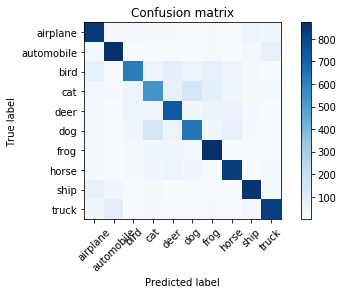

In [88]:
conf_matrix = confusion_matrix(y_true, pred)
print(conf_matrix)

plt.figure()
plot_confusion_matrix(conf_matrix, ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
plt.show()

## Convolutional Neural Network Predictions
The following cells will predict 5 random images.

In [89]:
x_sample = []
for x in x_test:
  img = skimage.transform.resize(x, (64, 64))
  x_sample.append(img)

Prediction: automobile
Actual: automobile


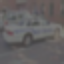



Prediction: truck
Actual: ship


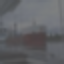



Prediction: deer
Actual: deer


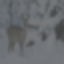



Prediction: dog
Actual: dog


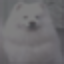



Prediction: dog
Actual: cat


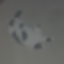

In [111]:
import random as rand

labels = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

rand_range = rand.randint(5, 10001)
i = rand_range - 5

for i in range(i, rand_range):
  print("Prediction: {}".format(labels[pred[i]]))
  print("Actual: {}".format(labels[y_true[i]]))
  pixels = x_sample[i].reshape(64, 64, 3)
  pixels = (pixels * 64) + 64
  pixels = pixels.astype(np.uint8)

  pic = Image.fromarray(pixels, 'RGB')
  display(pic)
  print("\n")

In [91]:
print(pred.shape)
print(y_true.shape)

(10000,)
(10000,)


## Part II:   CNN model with Transfer Learning
In this section, we if we can improve the previous model using the transfer learning technique. To accomplish this, we are using [VGG16](https://neurohive.io/en/popular-networks/vgg16/), a pre-trained model.

### Additional Notes
* VGG16 supports down to 48x48 images as an input, which conflicts with *our* 32x32 image resolution, and thus, we will upsaample our images.

In [92]:
# Reload data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)

print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)
50000 train samples
10000 test samples


In [93]:
import skimage.transform
from skimage.transform import resize

new_x_train = []

for x in x_train:
  img = skimage.transform.resize(x, (64, 64))
  new_x_train.append(img)
    
# this process may take about a few minutes ....

In [94]:
new_x_test = []

for x in x_test:
  img = skimage.transform.resize(x, (64, 64))
  new_x_test.append(img)

# this process may take about a few minutes ....

In [95]:
new_x_train = np.asarray(new_x_train)
new_x_test = np.asarray(new_x_test)

## One Hot Encoding
In the following cells, we convert y_train and y_test into 1D images by using reshape(). One-hot encoding is subsequently performed.

In [96]:
#convert y_train and y_test from 2D to 1D
y_train = y_train.reshape(50000)
y_test = y_test.reshape(10000)

In [97]:
# Convert class vectors to one hot format
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [98]:
# double check shape
print(y_train.shape)
print(y_test.shape)

# expected output:  (50000, 10)
# expected output:  (10000, 10)

(50000, 10)
(10000, 10)


In [99]:
print(new_x_train.shape)
print(new_x_test.shape)

(50000, 64, 64, 3)
(10000, 64, 64, 3)


## Load the VGG16 model


In [100]:
from tensorflow.keras.applications.vgg16 import VGG16

vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))   #  first hidden layer

transfer_model = Sequential()

for layer in vgg_model.layers:
  transfer_model.add(layer)

# print out the model summary
transfer_model.summary()


Model: "sequential_124"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 16, 16, 256)    

## Freeze model weights

In [101]:
for layer in transfer_model.layers:
  layer.trainable = False



###  Write your code in the cell below to add some "Dense" layers as top layers.

- Donot forget the output layer
- Choose the right activation fucntion for the output layer

In [102]:
transfer_model.add(Flatten())

# Add some "Dense" layers here, including output layer
transfer_model.add(Dense(512))
transfer_model.add(Activation(best_model[3][0]))
transfer_model.add(Dropout(0.5))
transfer_model.add(Dense(256, activation = best_model[3][0]))
transfer_model.add(Dense(128, activation = best_model[3][0]))
transfer_model.add(Dropout(0.5))

#output layer
transfer_model.add(Dense(10, activation = 'softmax'))

# print out the model summary
transfer_model.summary()


Model: "sequential_124"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 16, 16, 256)    

## Compile and fit transfer learning model

In [103]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

checkpointer = ModelCheckpoint(filepath="cnn/best_weights_transfer.hdf5", verbose=0, save_best_only=True) 

# compile transfer_model
transfer_model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=Adam(lr=0.001, decay=1e-6), metrics=['accuracy'])

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')
      
start = time.time()

transfer_model.fit(new_x_train, y_train, batch_size, callbacks=[monitor, checkpointer], epochs=100, verbose=2, validation_data=(new_x_test, y_test))

elapsed = time.time() - start
print ("Elapsed time: {}".format(hms_string(elapsed)))

# since we use GPU, the training time for each epoch for the transferred model is about 60 seconds.  
# Let it run for a few epochs. 

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 - 35s - loss: 1.5090 - acc: 0.4745 - val_loss: 1.0954 - val_acc: 0.6231
Epoch 2/100
50000/50000 - 18s - loss: 1.1855 - acc: 0.5997 - val_loss: 0.9915 - val_acc: 0.6617
Epoch 3/100
50000/50000 - 18s - loss: 1.0916 - acc: 0.6346 - val_loss: 0.9860 - val_acc: 0.6613
Epoch 4/100
50000/50000 - 18s - loss: 1.0439 - acc: 0.6479 - val_loss: 0.9341 - val_acc: 0.6797
Epoch 5/100
50000/50000 - 18s - loss: 1.0054 - acc: 0.6609 - val_loss: 0.9213 - val_acc: 0.6799
Epoch 6/100
50000/50000 - 18s - loss: 0.9670 - acc: 0.6730 - val_loss: 0.9141 - val_acc: 0.6916
Epoch 7/100
50000/50000 - 18s - loss: 0.9426 - acc: 0.6835 - val_loss: 0.8943 - val_acc: 0.6934
Epoch 8/100
50000/50000 - 18s - loss: 0.9128 - acc: 0.6895 - val_loss: 0.8951 - val_acc: 0.6928
Epoch 9/100
50000/50000 - 18s - loss: 0.8961 - acc: 0.6972 - val_loss: 0.8715 - val_acc: 0.7013
Epoch 10/100
50000/50000 - 18s - loss: 0.8804 - acc: 0.7030 - val_loss: 0.8690 - val_a

## Model Precision, Recall, F1 Score, Confusion Matrix

In [104]:
from sklearn import metrics

pred = transfer_model.predict(new_x_test)
pred = np.argmax(pred, axis=1)
y_true = np.argmax(y_test, axis=1)

In [105]:
score = metrics.accuracy_score(y_true, pred)
print("Accuracy: {}".format(score))

f1 = metrics.f1_score(y_true, pred, average='weighted')
print("F1 Score: {}".format(f1))

Accuracy: 0.7093
F1 Score: 0.7084612672685883


In [106]:
print(metrics.classification_report(y_true, pred))

              precision    recall  f1-score   support

           0       0.75      0.78      0.76      1000
           1       0.88      0.72      0.80      1000
           2       0.73      0.59      0.65      1000
           3       0.56      0.48      0.51      1000
           4       0.65      0.67      0.66      1000
           5       0.59      0.67      0.63      1000
           6       0.65      0.78      0.71      1000
           7       0.70      0.79      0.74      1000
           8       0.82      0.83      0.83      1000
           9       0.80      0.79      0.79      1000

    accuracy                           0.71     10000
   macro avg       0.71      0.71      0.71     10000
weighted avg       0.71      0.71      0.71     10000



[[776   9  44  16  25   9  16  23  63  19]
 [ 29 724   7  27  10  16  24  17  42 104]
 [ 53   1 595  39  95  70  96  43   6   2]
 [ 24   8  45 476  58 197 112  48  12  20]
 [ 21   1  33  48 668  39  78  91  12   9]
 [  7   2  23 117  54 672  43  64   7  11]
 [  6   9  35  57  46  52 778   6   8   3]
 [ 12   4  26  26  50  67  17 789   4   5]
 [ 62  16   9  14   9   5  16  13 828  28]
 [ 39  47   3  30  13  12   8  38  23 787]]


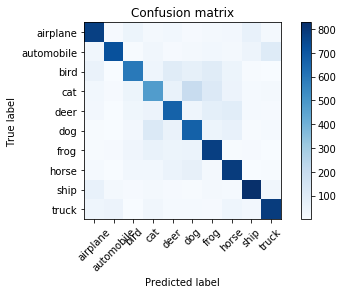

In [107]:
conf_matrix = confusion_matrix(y_true, pred)
print(conf_matrix)

plt.figure()
plot_confusion_matrix(conf_matrix, ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
plt.show()

## Transfer Learning Model Predictions
The following cells will predict the same 5 images as previously using the transfer learning model.

Prediction: automobile
Actual: automobile


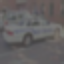



Prediction: truck
Actual: ship


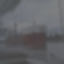



Prediction: deer
Actual: deer


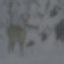



Prediction: dog
Actual: dog


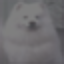



Prediction: dog
Actual: cat


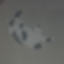

In [112]:
# reinitialize i
i = rand_range - 5

for i in range(i, rand_range):
  print("Prediction: {}".format(labels[pred[i]]))
  print("Actual: {}".format(labels[y_true[i]]))
  pixels = new_x_test[i].reshape(64, 64, 3)
  pixels = (pixels * 64) + 64
  pixels = pixels.astype(np.uint8)

  pic = Image.fromarray(pixels, 'RGB')
  display(pic)
  print("\n")